In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Data Process

In [5]:
def bin_sum(data, bin_size):
    """
    Perform sliding window 1ms summation on each column of a 2D numpy array.
    
    Args:
        data (np.ndarray): 2D array where summation is applied column-wise.
        bin_size (int): Size of the sliding window.
        
    Returns:
        np.ndarray: 2D array with summed values for each column based on the sliding window.
    """
    if bin_size > data.shape[0]:
        raise ValueError("bin_size cannot be larger than the number of rows in the data.")
    
    # Calculate the number of rows in the output
    output_rows = data.shape[0] - bin_size + 1
    output = np.zeros((output_rows, data.shape[1]))
    
    # Perform sliding window summation
    for i in range(output_rows):
        output[i, :] = np.sum(data[i:i+bin_size, :], axis=0)
    
    return output

In [60]:
neural_data=np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=1,usecols=range(5,51))
odor_data = np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=1,usecols=[1,4])

# neural_data = neural_data[odor_data[:, 0] != 5]
# odor_data = odor_data[odor_data[:, 0] != 5]

# Initialize lists to hold trial-wise batches
spike_data_list = []
odor_data_list = []
time_bin = 25
bin_size = 100
smooth = False
sigma = 10

# Iterate over trials
for i_trial in np.unique(odor_data[:, 1]):   
    # Extract the rows corresponding to the current trial
    neural_data_i_trial = neural_data[odor_data[:, 1] == i_trial]

    # # Perform sliding 1ms window for each entry
    # neural_bins_sum = bin_sum(neural_data_i_trial,bin_size)

    # Perform sum spike within bins
    remainder = neural_data_i_trial.shape[0] % time_bin
    if remainder != 0: 
        neural_bins_subset = neural_data_i_trial[:-remainder, :].reshape((-1, time_bin, 46))
    else: 
        neural_bins_subset = neural_data_i_trial.reshape((-1, time_bin, 46))

    # Sum the bins
    neural_bins_sum = np.sum(neural_bins_subset, axis=1)
    
    if smooth:
        neural_bins_sum = np.apply_along_axis(lambda col: gaussian_filter1d(col, sigma=sigma), axis=0, arr=neural_bins_sum)

    # Append spike data and labels for this trial
    spike_data_list.append(neural_bins_sum)
    odor_data_list.append(np.unique(odor_data[np.where(odor_data[:, 1] == i_trial), 0]))


# total number of trial
assert len(odor_data_list)==len(spike_data_list)
len(spike_data_list)

210

### make them into batches, depends on trials and label

In [ ]:
random.seed(40)
# Determine the maximum number of bins
max_bins = max(len(batch) for batch in spike_data_list)

# Pad each batch to have the same number of bins, fill the short with 0
padded_spike  = [
    np.pad(batch, ((0, max_bins - len(batch)), (0, 0)), mode='constant') for batch in spike_data_list
]
odor3d = np.stack(odor_data_list)

# Convert to tensors
padded_trials_tensor = torch.tensor(padded_spike, dtype=torch.float32)
labels_tensor = torch.tensor(odor3d, dtype=torch.int64)

# Shuffle trials and labels together
indices = list(range(len(padded_spike)))
random.shuffle(indices)
padded_trials_tensor = padded_trials_tensor[indices]
labels_tensor = labels_tensor[indices]

print(padded_trials_tensor.shape)

# Create batches
batch_size = 50
num_batches = len(padded_spike) // batch_size

batches = [
    padded_trials_tensor[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)
]

print(batches[0].shape)
batches = [x.float() for x in batches] # make sure every element is float

label_batches = [
    labels_tensor[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)
]


torch.Size([210, 69, 46])
torch.Size([50, 69, 46])


# LSTM VAE

### define model

In [62]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, latent_dim, num_layers, hidden_size):
        super(LSTMModel, self).__init__()

        # Variables
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim

        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,  # Dimension of continuous t
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first = True
        )

        # Latent space transformation
        self.mean = nn.Linear(in_features=hidden_size, out_features=latent_dim)
        self.log_variance = nn.Linear(in_features=hidden_size, out_features=latent_dim)

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=latent_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Reconstruction from LSTM output
        self.output_layer = nn.Linear(in_features=hidden_size, out_features=input_dim)

    def encode(self, x_list, lengths):
        """
        Encoder: Takes a list of input sequences with varying lengths and encodes them into latent space.
        x_list: List of tensors, each with shape (seq_len, input_dim).
        lengths: Tensor of sequence lengths (batch_size).
        """
        # Pad sequences to the same length and pack them
        x_padded = torch.nn.utils.rnn.pad_sequence(x_list, batch_first=True)  # (batch_size, max_seq_len, input_dim)
        packed_input = pack_padded_sequence(x_padded, lengths, batch_first=True, enforce_sorted=False)

        # Pass through LSTM
        packed_output, (hidden, _) = self.encoder_lstm(packed_input)

        # Unpack output (optional)
        _, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Use the last hidden state from the final layer
        hidden = hidden[-1]  # (batch_size, hidden_size)

        # Compute mean and log-variance for latent space
        mean = self.mean(hidden)  # (batch_size, latent_dim)
        logvar = self.log_variance(hidden)  # (batch_size, latent_dim)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
            """
            Reparameterization trick to sample from N(mean, var).
            """
            std = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(std)
            return mean + epsilon * std

    def decode(self, z, lengths):
        """
        Decoder: Reconstruct sequences from latent representation.
        z: (batch_size, latent_dim)
        lengths: Tensor of sequence lengths (batch_size).
        """
        # Repeat latent vector for the max sequence length
        max_seq_len = lengths.max().item()
        z_repeated = z.unsqueeze(1).repeat(1, max_seq_len, 1)  # (batch_size, max_seq_len, latent_dim)

        # Decode latent space through LSTM
        packed_z = pack_padded_sequence(z_repeated, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.decoder_lstm(packed_z)

        # Unpack the output
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)  # (batch_size, max_seq_len, hidden_size)

        # Reconstruction through output layer
        output = self.output_layer(lstm_out)  # (batch_size, max_seq_len, input_dim)
        return output

    def forward(self, x_list):
        """
        Forward pass: Encoder -> Reparameterize -> Decoder.
        x_list: List of tensors with varying lengths, each with shape (seq_len, input_dim).
        """
        # Calculate lengths of sequences
        lengths = torch.tensor([x.size(0) for x in x_list], dtype=torch.long)

        # Encode input to latent space
        mean, logvar = self.encode(x_list, lengths)

        # Reparameterize
        z = self.reparameterize(mean, logvar)

        # Decode latent vector back to input space
        reconstructed_x = self.decode(z, lengths)

        return reconstructed_x, mean, logvar, z
    
# Loss function (binary cross-entropy + KL divergence)
def loss_function(recon_x, x, mu, logvar, beta=1):
    """
    Custom loss function: reconstruction loss + KL divergence.
    Args:
        recon_x (torch.Tensor): Reconstructed output (batch_size, max_seq_len, input_dim)
        x (torch.Tensor): Original input (batch_size, max_seq_len, input_dim)
        mu (torch.Tensor): Latent space mean (batch_size, latent_dim)
        logvar (torch.Tensor): Latent space log variance (batch_size, latent_dim)
        beta (float): Weight for KL divergence
    Returns:
        torch.Tensor: Reconstruction + KL divergence loss
    """
    
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')/ x.size(0)

    # KL divergence between encoder's distribution and standard Gaussian
    KL =  - beta * 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KL

## call the model

In [63]:
input_dim = 46
hidden_size = 128
latent_dim = 2
num_layers = 4

# Initial the model and optimizer
model = LSTMModel(input_dim=input_dim, latent_dim = latent_dim, num_layers=num_layers, hidden_size=hidden_size)
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# init 
epochs = 100
reconstruction_losses=[]
latent_vectors = []
all_labels = []  # labels or batch indices for coloring

# Training loop
for epoch in range(epochs):
    total_loss = 0
    model.train()

    for batch_idx, batch in enumerate(batches):
        #print(batch_idx)
        batch = batch.to(device)
        #print(label_batches[batch_idx])
        # Forward pass
        reconstructed_x, mu, logvar, z = model(batch)

        # Append latent vectors (detach to avoid memory issues)
        latent_vectors.append(z.detach().cpu())
        all_labels.append(label_batches[batch_idx].flatten()) 

        # Compute loss
        loss = loss_function(reconstructed_x, batch, mu, logvar, beta = 1)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {total_loss / num_batches:.4f}")
    reconstruction_losses.append(total_loss / num_batches)


Epoch [1/100] Average Loss: 311.6686
Epoch [2/100] Average Loss: 278.2441
Epoch [3/100] Average Loss: 262.9861
Epoch [4/100] Average Loss: 260.1926
Epoch [5/100] Average Loss: 258.8313
Epoch [6/100] Average Loss: 257.6024
Epoch [7/100] Average Loss: 256.9475
Epoch [8/100] Average Loss: 256.4825
Epoch [9/100] Average Loss: 256.0821
Epoch [10/100] Average Loss: 255.6050
Epoch [11/100] Average Loss: 255.2003
Epoch [12/100] Average Loss: 254.6749
Epoch [13/100] Average Loss: 253.9926
Epoch [14/100] Average Loss: 253.1123
Epoch [15/100] Average Loss: 252.3385
Epoch [16/100] Average Loss: 251.9072
Epoch [17/100] Average Loss: 250.3234
Epoch [18/100] Average Loss: 249.8608
Epoch [19/100] Average Loss: 249.5323
Epoch [20/100] Average Loss: 249.1194
Epoch [21/100] Average Loss: 248.5720
Epoch [22/100] Average Loss: 247.7505
Epoch [23/100] Average Loss: 247.3407
Epoch [24/100] Average Loss: 248.5972
Epoch [25/100] Average Loss: 247.4924
Epoch [26/100] Average Loss: 246.4979
Epoch [27/100] Averag

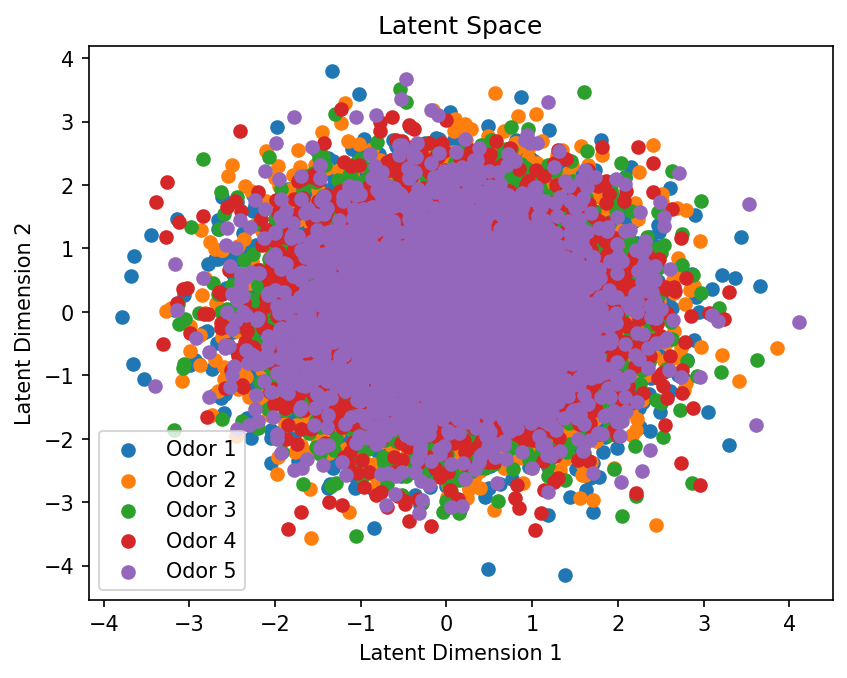

In [65]:
# Combine latent vectors and labels
latent_vectors = torch.cat(latent_vectors, dim=0).numpy()  # Shape: (total_samples, latent_dim)
all_labels = torch.cat(all_labels).numpy()  # Shape: (total_samples,)

# plot latent space
plt.figure(dpi=150)

for i in range(1,6):
    mask = all_labels == i  # Mask for points corresponding to odor i
    plt.scatter(latent_vectors[mask, 0], latent_vectors[mask, 1], label=f'Odor {int(i)}')

# Add legend and labels
plt.legend()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space")
plt.show()

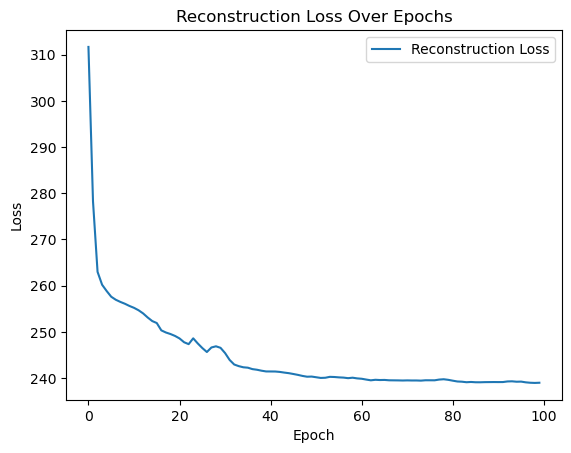

In [66]:
# Plot the losses
plt.figure(dpi=100)
plt.plot(range(0,epochs,1),reconstruction_losses, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Reconstruction Loss Over Epochs")
plt.legend()
plt.show()